<a href="https://colab.research.google.com/github/carlos-calderon-cabezas/traffic-analysis/blob/main/Traffic_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis y Predicciones de Datos de Tráfico Vehicular

## Introducción

El presente proyecto es una demostración breve y sencilla del análisis de datos y las predicciones de tráfico vehicular que yo realizaba para una empresa importante en Ecuador, dedicada a los estudios, planificación y construcción de proyectos de infraestructura vial. En este caso concreto, se trataba de la ampliación de una carretera.

Dadas las políticas de confidencialidad de la empresa en cuanto a los datos del proyecto, no me es posible incluir el total de parámetros obtenidos por este sensor, ni todas las variables que formaron parte del estudio, ni proporcionar la ubicación exacta del mismo. Asimismo, se han modificado intencionalmente parte de los datos que se muestran aquí.

Este proyecto se realiza con datos obtenidos de mediciones de tráfico vehicular realizadas entre el 2 de agosto de 2021 y el 12 de octubre de 2021, en un total de 71 días continuos.

Para realizar el proyecto, se colocó un sensor de tráfico en un tramo estratégico de la vía, el cual era capaz de contar los vehículos que pasaban y detectar características tales como el tipo de vehículo, su velocidad, así como la fecha y hora en que circulaban. En el dataset correspondiente al sensor o medidor de tráfico (*sensor_df*), cada fila representa la cantidad por hora de vehículos que han circulado por cada tipo, su velocidad promedio y su velocidad en el percentil 85.

Adicionalmente, se tiene un conjunto de datos correspondiente al estado del clima en el momento en que se tomaron los datos del tráfico. Estos datos también fueron registrados durante cada una de las 24 horas de cada uno de los 71 días de mediciones de tráfico. Se pueden obtener datos climáticos históricos de diferentes partes del mundo en [Visual Crossing](https://www.visualcrossing.com/weather/weather-data-services).

En el proyecto se analizan datos como, por ejemplo, la cantidad de vehículos que pasan a determinada hora o los días de la semana con más vehículos de un cierto tipo, etc.

En el análisis predictivo de este proyecto, se estudia el comportamiento del flujo vehicular influenciado por el día de la semana, la hora y el estado del clima actual.


## Importación inicial de librerías

Se importan las librerías necesarias y se lee el archivo correspondiente a las mediciones realizadas por el sensor de tráfico.

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
g_drive_path = "/content/drive/MyDrive/PORTFOLIO/Traffic_Analysis"
if os.path.exists(g_drive_path):
    os.chdir("/content/drive/MyDrive/PORTFOLIO/Traffic_Analysis")

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Exploración y Limpieza de Datos en conjunto de datos ***sensor_df***

In [4]:
sensor_df = pd.read_csv("./input/norte_sur_df.csv")

Debido a que el archivo de datos contiene contiene no solo las horas del día, pero también rangos de horas en el día, estos últimos se eliminan de momento para evitar problemas de lectura.

In [5]:
valores_a_quitar = ["07-19", "06-22", "06-00", "00-00"]

In [6]:
sensor_df = sensor_df[~sensor_df["Time"].isin(valores_a_quitar)]

Se crea una función para convertir las horas a formato numérico, dado que están en un formato ilegible para pandas.

In [7]:
def convert_time_to_hour(time_str):
    if time_str.isdigit() and len(time_str) == 4:
        hour = int(time_str[:2])
        return hour
    return time_str

# Aplicar la conversión a la columna "Time" utilizando .loc[]
sensor_df["Time"] = sensor_df["Time"].apply(convert_time_to_hour)
sensor_df["Time"] = sensor_df["Time"].astype("int64")

In [8]:
sensor_df["Date"] = pd.to_datetime(sensor_df["Date"])

In [9]:
print(f"Fecha inicial de las mediciones: {sensor_df['Date'].min()}")
print(f"Fecha final de las mediciones: {sensor_df['Date'].max()}")
total_dias = (sensor_df["Date"].max() - sensor_df["Date"].min()).days
print(f"Cantidad de días en que se realizaron las mediciones: {total_dias}")

Fecha inicial de las mediciones: 2021-08-02 00:00:00
Fecha final de las mediciones: 2021-10-12 00:00:00
Cantidad de días en que se realizaron las mediciones: 71


El sensor tiene la capacidad de detectar los vehículos que pasan sobre el en un total de 13 categorías, que van desde *Cls* hasta *Cls.13*, sin embargo, en el caso de este proyecto para propósitos de simplificación en el análisis, se definen simplemente se suman las columnas correspondientes para tener un total de tres (3) principales categorías de vehículos: Ligero (*Light*), Mediano (*Medium*), y Pesado (*Heavy*).

In [10]:
sensor_df["Light"] = sensor_df[["Cls", "Cls.1", "Cls.2"]].sum(axis=1)
sensor_df["Medium"] = sensor_df[[
    "Cls.3",
    "Cls.4",
    "Cls.5",
    "Cls.6"]].sum(axis=1)
sensor_df["Heavy"] = sensor_df[[
    "Cls.7", "Cls.8", "Cls.9", "Cls.10", "Cls.11", "Cls.12"
    ]].sum(axis=1)

columns_to_drop = [
    "Cls",
    "Cls.1",
    "Cls.2",
    "Cls.3",
    "Cls.4",
    "Cls.5",
    "Cls.6",
    "Cls.7",
    "Cls.8",
    "Cls.9",
    "Cls.10",
    "Cls.11",
    "Cls.12"]

sensor_df.drop(columns=columns_to_drop, inplace=True)

In [11]:
sensor_df.head(3)

,Date,Time,Total,Mean,Vpp,Light,Medium,Heavy
0,2021-08-02,15,92,66.5,96.5,83,7,2
1,2021-08-02,16,346,64.9,78.5,263,45,38
2,2021-08-02,17,369,72.3,86.9,273,70,26


Se reordenan las columnas para una mejor visualización.

In [12]:
sensor_df = sensor_df[[
    "Date",
    "Time",
    "Light",
    "Medium",
    "Heavy",
    "Total",
    "Mean",
    "Vpp"]]

In [13]:
sensor_df.sample(3)

,Date,Time,Light,Medium,Heavy,Total,Mean,Vpp
437,2021-08-18,4,0,0,0,0,-,-
1043,2021-09-08,22,72,58,70,200,66.2,78.7
1780,2021-10-05,3,0,0,0,0,-,-


In [14]:
sensor_df.drop(["Date"], axis= 1).describe()

,Time,Light,Medium,Heavy,Total
count,1705.000000,1705.000000,1705.000000,1705.000000,1705.000000
mean,11.502053,113.856305,39.819941,21.250440,174.926686
std,6.922705,105.692018,31.905392,20.031695,143.440746
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,84.000000,47.000000,20.000000,190.000000
75%,17.000000,218.000000,66.000000,34.000000,302.000000
max,23.000000,364.000000,126.000000,101.000000,492.000000


### Tratamiento de valores faltantes y nulos.

In [15]:
sensor_df.isna().sum()

Date      0
Time      0
Light     0
Medium    0
Heavy     0
Total     0
Mean      0
Vpp       0
dtype: int64

Se puede observar que la cantidad de valores faltantes o nulos en el DataFrame es cero (0). No obstante, para asegurar la calidad y la integridad de los datos, es necesario realizar un análisis más profundo. En particular, es importante verificar si en ciertos momentos específicos el sensor no registró ningún dato, lo cual podría no estar reflejado en los valores nulos, sino en registros donde el total de lecturas es igual a cero (0). Para esto, se cuentan todas las filas donde el valor total de las lecturas (`Total`) es igual a cero, ya que esto indicaría que en esos momentos no se registraron datos por parte del sensor.

In [16]:
# Contar las filas donde los valores de "Light", "Medium" y "Heavy" sean 0
zero_count = sensor_df[(sensor_df["Total"] == 0)].shape[0]

print(f"Número de filas en sensor_df donde "
        f"los valores de 'Total' son 0: {zero_count}")
print(f"El total de observaciones es {sensor_df.shape[0]}")
print(f"Porcentaje de valores faltantes: "
        f"{zero_count / sensor_df.shape[0] * 100:.2f} %")

Número de filas en sensor_df donde los valores de 'Total' son 0: 554
El total de observaciones es 1705
Porcentaje de valores faltantes: 32.49 %


In [17]:
sensor_df.columns

Index(['Date', 'Time', 'Light', 'Medium', 'Heavy', 'Total', 'Mean', 'Vpp'], dtype='object')

Dado que los registros donde el contador marca cero (0) para vehículos livianos, medianos y pesados corresponden a momentos en que el contador fue desconectado, y no a la ausencia real de vehículos en esos momentos, es posible eliminar de manera segura estos registros. Estos valores no representan datos faltantes en el sentido de que no haya habido tránsito, sino que indican un fallo en la recolección de datos debido a la desconexión del contador.

A continuación, se eliminan los registros sin mediciones de tráfico.

In [18]:
# Se crea un panda series temporal donde los valores de "Total" son = 0
zero_rows = (sensor_df["Total"] == 0)

# Eliminar las filas que cumplen con la condición
sensor_df = sensor_df.drop(sensor_df[zero_rows].index)

### Conversión de columnas a los tipos correctos

In [19]:
sensor_df["Time"] = sensor_df["Time"].astype("int64")

In [20]:
sensor_df["Vpp"].replace({"-": np.nan}, inplace=True)
sensor_df.dropna(subset=["Vpp"], inplace=True)
sensor_df[["Mean", "Vpp"]] = sensor_df[["Mean", "Vpp"]].astype("float64")

print(sensor_df.dtypes)

Date      datetime64[ns]
Time               int64
Light              int64
Medium             int64
Heavy              int64
Total              int64
Mean             float64
Vpp              float64
dtype: object


#### Detección de ***outliers***

Ahora que se han eliminado los registros nulos, se procede a detectar valores atípicos *(outliers)* con el fin de mejorar el rendimiento del posterior modelo de machine learning.

In [21]:
sensor_df.drop(["Date"], axis= 1).describe()

,Time,Light,Medium,Heavy,Total,Mean,Vpp
count,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000
mean,11.584575,170.114812,59.503067,31.754601,261.372480,69.725942,84.057318
std,6.820962,84.385487,18.690631,16.307766,90.242979,4.361387,5.078292
min,0.000000,17.000000,7.000000,0.000000,24.000000,48.800000,61.000000
25%,6.000000,83.000000,47.000000,19.000000,189.000000,66.900000,81.000000
50%,12.000000,192.000000,60.000000,29.000000,273.000000,69.700000,84.300000
75%,17.000000,239.000000,72.000000,42.000000,333.000000,72.600000,87.500000
max,23.000000,364.000000,126.000000,101.000000,492.000000,83.700000,104.200000


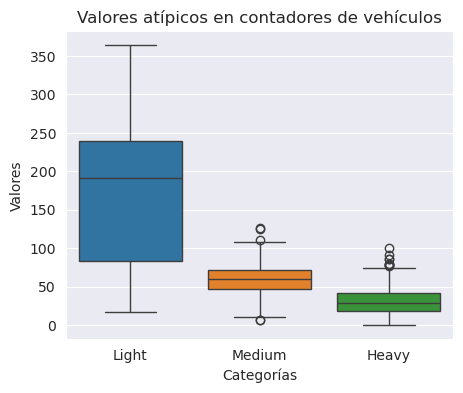

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
sns.boxplot(data=sensor_df[["Light", "Medium", "Heavy"]])
plt.title("Valores atípicos en contadores de vehículos")
plt.xlabel("Categorías")
plt.ylabel("Valores")
plt.show()

In [23]:
# Función para calcular los límites inferior y superior
def limites_outliers(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Se obtienen los límites para cada columna
lb_light, ub_light = limites_outliers(sensor_df["Light"])
lb_medium, ub_medium = limites_outliers(sensor_df["Medium"])
lb_heavy, ub_heavy = limites_outliers(sensor_df["Heavy"])

# Se filtran los valores dentro de los límites
sensor_df = sensor_df[
    (sensor_df["Light"] >= lb_light) & (sensor_df["Light"] <= ub_light) &
    (sensor_df["Medium"] >= lb_medium) & (sensor_df["Medium"] <= ub_medium) &
    (sensor_df["Heavy"] >= lb_heavy) & (sensor_df["Heavy"] <= ub_heavy)
]

In [24]:
sensor_df.head(3)

,Date,Time,Light,Medium,Heavy,Total,Mean,Vpp
1,2021-08-02,16,263,45,38,346,64.9,78.5
2,2021-08-02,17,273,70,26,369,72.3,86.9
3,2021-08-02,18,236,69,53,358,68.3,83.2


## Preprocesamiento del conjunto de datos históricos del clima

Se lee el conjunto de datos históricos del clima al momento de las mediciones de tráfico y se convierte la columna de **datetime** (fecha) en un formato adecuado para pandas.

In [25]:
# Leer el archivo CSV
weather_df = pd.read_csv("./input/weather_df.csv")

# Convertir la columna 'datetime' al tipo datetime
weather_df["datetime"] = pd.to_datetime(weather_df["datetime"])

Se mapean los días al español para una mayor facilidad de lectura, y se extraen las fechas y horas provenientes del *timestamp*.:

In [26]:
days_map = {
    "Monday": "Lunes",
    "Tuesday": "Martes",
    "Wednesday": "Miércoles",
    "Thursday": "Jueves",
    "Friday": "Viernes",
    "Saturday": "Sábado",
    "Sunday": "Domingo"
}

In [27]:
weather_df["fecha"] = weather_df["datetime"].dt.date
weather_df["hora"] = weather_df["datetime"].dt.hour

Se convierten las columnas *clima* y *dia_semana* al tipo categórico para su posterior tratamiento.

In [28]:
weather_df["dia_semana"] = weather_df["datetime"].dt.day_name().map(days_map)
weather_df.drop(["datetime"], axis= 1, inplace= True)
weather_df.rename(columns= {"conditions": "clima"}, inplace= True)
weather_df['fecha'] = pd.to_datetime(weather_df['fecha'])
weather_df["clima"] = weather_df["clima"].astype("category")
weather_df["dia_semana"] = weather_df["dia_semana"].astype("category")

In [29]:
weather_df.sample(3)

,clima,fecha,hora,dia_semana
576,Parc_nublado,2021-08-26,0,Jueves
1509,Parc_nublado,2021-10-03,21,Domingo
499,Parc_nublado,2021-08-22,19,Domingo


Se comprueban los valores que puede tomar la categoría de *clima* y los tipos de datos del dataframe *weather_df*.

In [30]:
weather_df["dia_semana"].unique()

['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
Categories (7, object): ['Domingo', 'Jueves', 'Lunes', 'Martes', 'Miércoles', 'Sábado', 'Viernes']

In [31]:
weather_df["clima"].unique()

['Parc_nublado', 'Lluvia', 'Nublado', 'Despejado']
Categories (4, object): ['Despejado', 'Lluvia', 'Nublado', 'Parc_nublado']

In [32]:
weather_df.dtypes

clima               category
fecha         datetime64[ns]
hora                   int32
dia_semana          category
dtype: object

## Unión de conjuntos de datos del *tráfico* con el conjunto de datos históricos del *clima*.

Se unen a continuación, los conjuntos de datos de tráfico y clima mediante el comando **merge** de pandas, a fin de comenzar con el análisis de los datos.

In [33]:
# Se cambian temporalmente los nombres de las columnas para
# que coincidan con "traffic_df"
sensor_df.rename(columns={"Date": "fecha", "Time": "hora"}, inplace=True)

# Se unen los DataFrames usando las columnas "fecha" y "hora"
traffic_df = pd.merge(sensor_df, weather_df, on=["fecha", "hora"])

# Se proyecta en pantalla las primeras filas del DataFrame resultante
traffic_df.rename(columns={"fecha": "Date", "hora": "Time"}, inplace=True)
traffic_df["Mean"].astype("float64")

traffic_df.head(3)

,Date,Time,Light,Medium,Heavy,Total,Mean,Vpp,clima,dia_semana
0,2021-08-02,16,263,45,38,346,64.9,78.5,Parc_nublado,Lunes
1,2021-08-02,17,273,70,26,369,72.3,86.9,Parc_nublado,Lunes
2,2021-08-02,18,236,69,53,358,68.3,83.2,Parc_nublado,Lunes


Se realiza el tratamiento de valores nulos a columna **Vpp**, misma que corresponde a la velocidad en el percentil 85. Para ello, se cuentan en primer lugar la cantidad de valores nulos de dicha columna. En este caso, el contador de tráfico ha representado los valores nulos en dicha columna con el símbolo de guión intermedio (-).

In [34]:
# Conteo de valores nulos el columna "Vpp"
nulos_en_vpp = traffic_df["Vpp"].replace("-", pd.NA).isna().sum()
total_filas = len(traffic_df)
porcentaje_de_nulos = (nulos_en_vpp / total_filas) * 100
print(f"La cantidad de nulos en la columna 'vpp' es: {nulos_en_vpp}")
print(f"La cantidad total de filas de 'traffic_df' es: {total_filas}")
print(f"El porcentaje de nulos en 'Vpp' es: {porcentaje_de_nulos}%")

La cantidad de nulos en la columna 'vpp' es: 0
La cantidad total de filas de 'traffic_df' es: 1127
El porcentaje de nulos en 'Vpp' es: 0.0%


Al existir una cantidad muy baja de valores nulos (menos del 1%), se pueden eliminar las filas que contienen dichos valores de manera segura. Se podría revisar el manual de usuario del contador de tráfico para obtener más detalles de porque en algunas entradas no consta el mencionado valor.

Adicionalmente, se cambia el tipo de columna a coma flotante (*float64*) para su posterior análisis.

In [35]:
traffic_df["Vpp"].replace("-", pd.NA, inplace= True)
traffic_df["Vpp"].fillna(traffic_df["Vpp"].median(), inplace= True)
traffic_df["Vpp"].astype("float64")

0       78.5
1       86.9
2       83.2
3       81.0
4       82.4
        ... 
1122    85.7
1123    86.8
1124    84.1
1125    83.9
1126    64.6
Name: Vpp, Length: 1127, dtype: float64

In [36]:
traffic_df.head(3)

,Date,Time,Light,Medium,Heavy,Total,Mean,Vpp,clima,dia_semana
0,2021-08-02,16,263,45,38,346,64.9,78.5,Parc_nublado,Lunes
1,2021-08-02,17,273,70,26,369,72.3,86.9,Parc_nublado,Lunes
2,2021-08-02,18,236,69,53,358,68.3,83.2,Parc_nublado,Lunes


## Análisis de datos sobre el flujo vehicular en la carretera

A continuación se realiza un análisis de datos sencillo para ver la influencia de distintas variables, como la hora del día, el día de la semana o el clima influyen sobre el volumen del tráfico.

In [37]:
# traffic_df.columns

### Variación del tráfico según el día de la semana

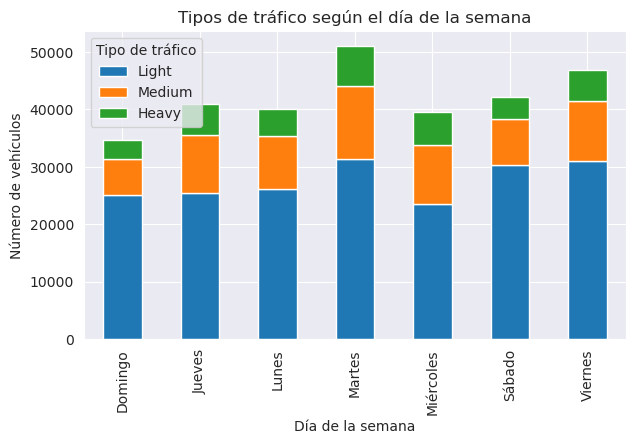

In [38]:
grouped_df = traffic_df.groupby("dia_semana")[[
    "Light", "Medium", "Heavy"]].sum()

# Crear el gráfico de barras apiladas
grouped_df.plot(kind="bar", stacked=True, figsize=(7, 4))

# Añadir títulos y etiquetas
plt.title("Tipos de tráfico según el día de la semana")
plt.xlabel("Día de la semana")
plt.ylabel("Número de vehículos")
plt.legend(title="Tipo de tráfico")

# Mostrar el gráfico
plt.show()

La gráfica de barras apiladas muestra que el volumen total de tráfico varía a lo largo de la semana, con los martes y viernes teniendo los mayores volúmenes, mientras que los domingos y jueves tienen los menores. En todos los días, los vehículos ligeros son los más numerosos, seguidos por los medianos y, en menor cantidad, los pesados. Los martes destacan por tener un volumen significativamente mayor de vehículos pesados, lo que sugiere una mayor actividad de transporte al inicio de la semana laboral. Esta información puede ser útil para la planificación y gestión del tráfico.

### Variación del tráfico según la hora del día

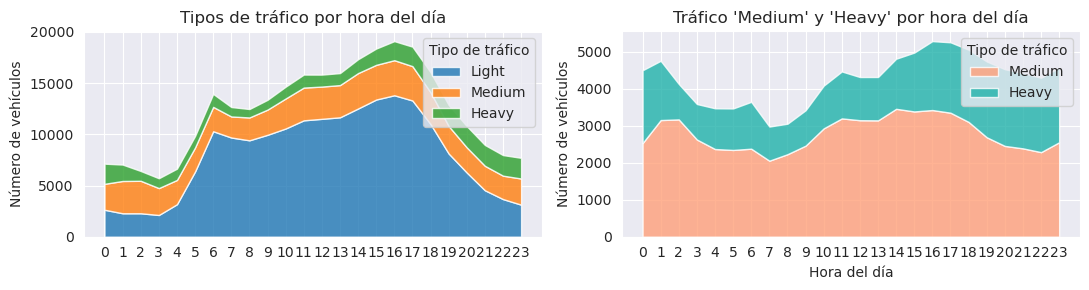

In [39]:
# Agrupar los datos por hora y sumar los valores de cada tipo de tráfico
grouped_by_hour_df = traffic_df.groupby("Time")[["Light", "Medium", "Heavy"]].sum()

# Crear la figura y los subplots
fig, axs = plt.subplots(1, 2, figsize=(11, 3), sharex=True)

# Gráfico de líneas apiladas para todos los tipos de tráfico
axs[0].stackplot(grouped_by_hour_df.index,
                 grouped_by_hour_df["Light"],
                 grouped_by_hour_df["Medium"],
                 grouped_by_hour_df["Heavy"],
                 labels=["Light", "Medium", "Heavy"], alpha=0.8)
axs[0].set_title("Tipos de tráfico por hora del día")
axs[0].set_ylabel("Número de vehículos")
axs[0].legend(title="Tipo de tráfico")

# Gráfico de líneas apiladas solo para Medium y Heavy
axs[1].stackplot(grouped_by_hour_df.index,
                 grouped_by_hour_df["Medium"],
                 grouped_by_hour_df["Heavy"],
                 labels=["Medium", "Heavy"], alpha=0.8, colors=['#FFA07A', '#20B2AA'])
axs[1].set_title("Tráfico 'Medium' y 'Heavy' por hora del día")
axs[1].set_xlabel("Hora del día")
axs[1].set_ylabel("Número de vehículos")
axs[1].legend(title="Tipo de tráfico")

# Asegurar que todas las horas se muestran en el eje x
plt.xticks(grouped_by_hour_df.index)

# Ajustar los layouts
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Los gráficos de líneas apiladas muestran cómo varía el volumen de tráfico a lo largo del día para diferentes tipos de vehículos. En el primer gráfico, que incluye vehículos ligeros (Light), medianos (Medium) y pesados (Heavy), se observa que el tráfico comienza a aumentar alrededor de las 5 a.m., alcanza su primer pico entre las 7 y las 9 a.m., y luego disminuye ligeramente antes de volver a aumentar durante la tarde, alcanzando un segundo pico alrededor de las 5 p.m. Posteriormente, el tráfico disminuye gradualmente hasta la medianoche. Los vehículos ligeros son predominantemente más numerosos a lo largo de todo el día.

En el segundo gráfico, que se enfoca solo en los vehículos medianos y pesados, se puede ver una tendencia similar con dos picos principales, uno en la mañana y otro en la tarde. Sin embargo, la proporción de vehículos pesados es más notable durante estos periodos de mayor tráfico. Esta visualización resalta que tanto los vehículos medianos como los pesados tienen patrones de tráfico similares, con un tráfico más intenso durante las horas pico de la mañana y la tarde.

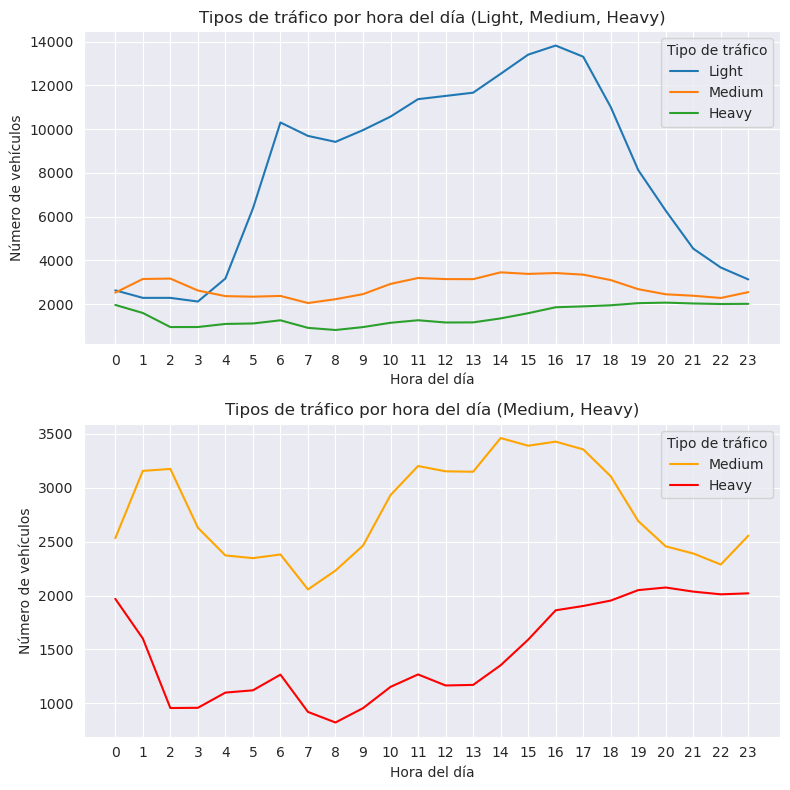

In [40]:
# Crear el gráfico de líneas separadas para "Light", "Medium" y "Heavy"
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(grouped_by_hour_df.index, grouped_by_hour_df["Light"], label="Light")
plt.plot(grouped_by_hour_df.index, grouped_by_hour_df["Medium"], label="Medium")
plt.plot(grouped_by_hour_df.index, grouped_by_hour_df["Heavy"], label="Heavy")
plt.title("Tipos de tráfico por hora del día (Light, Medium, Heavy)")
plt.xlabel("Hora del día")
plt.ylabel("Número de vehículos")
plt.legend(title="Tipo de tráfico")
plt.xticks(grouped_by_hour_df.index)

# Crear el gráfico de líneas separadas para "Medium" y "Heavy"
plt.subplot(2, 1, 2)
plt.plot(grouped_by_hour_df.index, grouped_by_hour_df["Medium"], label="Medium", color="orange")
plt.plot(grouped_by_hour_df.index, grouped_by_hour_df["Heavy"], label="Heavy", color="red")
plt.title("Tipos de tráfico por hora del día (Medium, Heavy)")
plt.xlabel("Hora del día")
plt.ylabel("Número de vehículos")
plt.legend(title="Tipo de tráfico")
plt.xticks(grouped_by_hour_df.index)

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()

### Variación del tráfico según el día de la semana y la hora del día

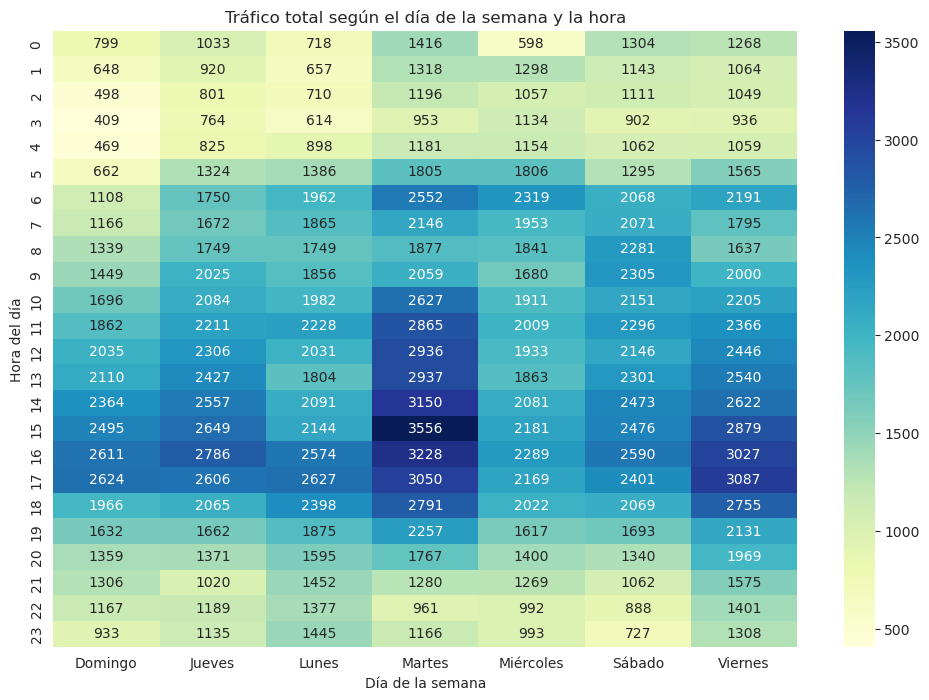

In [41]:
# Agrupar los datos por día de la semana y hora, y sumar los valores de cada tipo de tráfico
grouped_df = traffic_df.groupby(["dia_semana", "Time"])[["Light", "Medium", "Heavy", "Total"]].sum().reset_index()

# Pivotear los datos para el heatmap
pivot_df = grouped_df.pivot(index="Time", columns="dia_semana", values="Total")

# Crear el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, cmap="YlGnBu", annot=True, fmt="d")

# Añadir títulos y etiquetas
plt.title("Tráfico total según el día de la semana y la hora")
plt.xlabel("Día de la semana")
plt.ylabel("Hora del día")

# Mostrar el gráfico
plt.show()


El mapa de calor muestra que el tráfico total varía significativamente según el día de la semana y la hora del día. Los martes y viernes tienen los mayores volúmenes de tráfico, especialmente durante las horas pico de la tarde (16:00 a 18:00), mientras que los domingos y jueves presentan menores volúmenes de tráfico. El tráfico generalmente aumenta a partir de las 6 a.m., alcanzando picos alrededor de las 7 a.m. y las 8 a.m., con un segundo pico en la tarde entre las 4 p.m. y las 6 p.m. Después de las 8 p.m., el tráfico disminuye considerablemente.

### Variación de la velocidad para cada tipo de vehículo según el clima

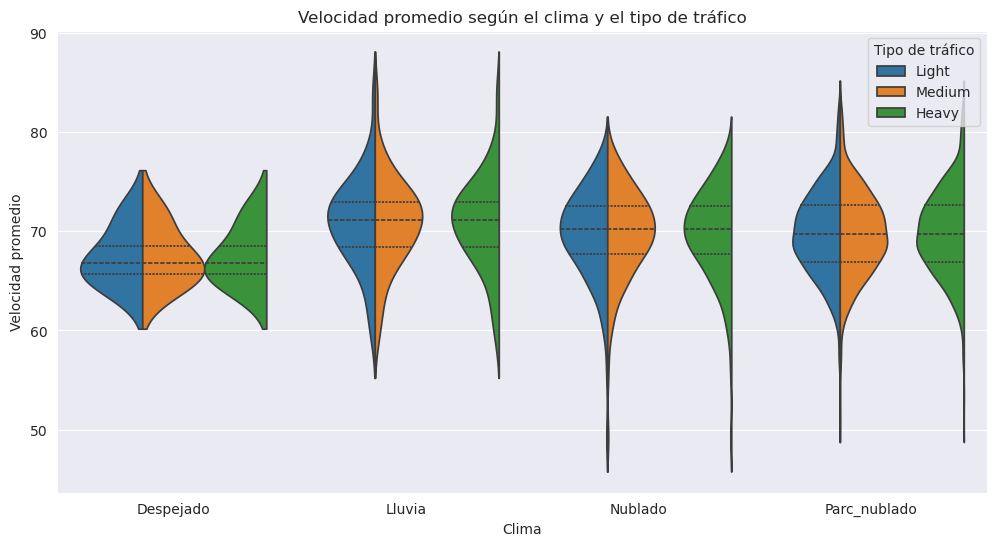

In [42]:
# Convertir el DataFrame a formato largo (long format)
traffic_df_long = traffic_df.melt(id_vars=["Date", "Time", "clima", "Mean"],
                                  value_vars=["Light", "Medium", "Heavy"],
                                  var_name="TrafficType",
                                  value_name="Count")

# Crear el gráfico de violín para la velocidad promedio según el clima y el tipo de tráfico
plt.figure(figsize=(12, 6))
sns.violinplot(x="clima", y="Mean", hue="TrafficType", data=traffic_df_long, inner="quartile", split=True)

# Añadir títulos y etiquetas
plt.title("Velocidad promedio según el clima y el tipo de tráfico")
plt.xlabel("Clima")
plt.ylabel("Velocidad promedio")
plt.legend(title="Tipo de tráfico")

# Mostrar el gráfico
plt.show()

Según la gráfica anterior se puede ver que, en condiciones de lluvia, hay una tendencia a que las velocidades promedio sean más bajas y más dispersas, lo cual sugiere que los conductores tienden a reducir la velocidad y que hay una mayor variabilidad en la forma en que diferentes conductores reaccionan a la lluvia.
En condiciones despejadas, las velocidades son más consistentes y más altas, lo que sugiere que los conductores se sienten más seguros y tienden a mantener velocidades más constantes.
Condiciones nubladas y parcialmente nubladas muestran patrones intermedios, con algo de dispersión en las velocidades pero no tanto como en condiciones de lluvia.

No obstante, se puede notar que, no parece haber una diferencia significativa en las velocidades promedio entre los tipos de vehículos (Light, Medium, Heavy) bajo las mismas condiciones climáticas. Esto podría sugerir que todos los tipos de vehículos se ven igualmente afectados por las condiciones climáticas en términos de velocidad.

### Histograma de las velocidades media y en percentil 85

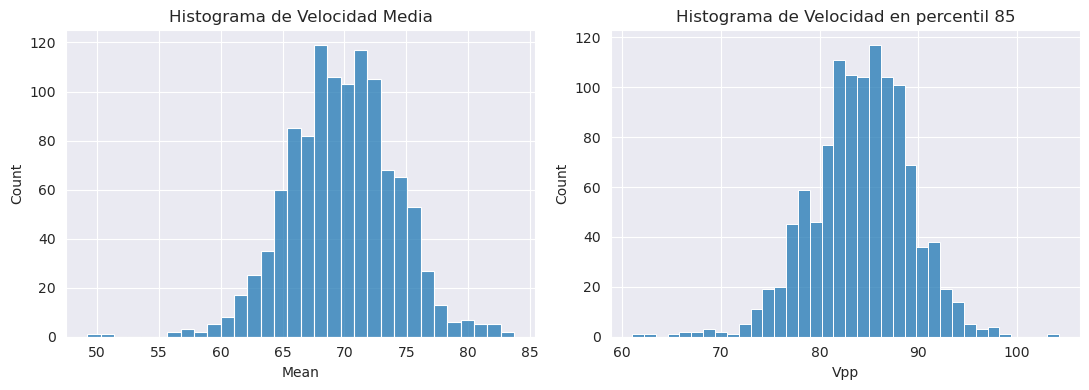

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

sns.histplot(data=traffic_df, x="Mean", ax=axes[0])
axes[0].set_title("Histograma de Velocidad Media")

sns.histplot(data=traffic_df, x="Vpp", ax=axes[1])
axes[1].set_title("Histograma de Velocidad en percentil 85")

plt.tight_layout()
plt.show()

Se puede ver en el anterior histograma que de manera general, la velocidad media de los vehículos va entre los 65 y 75 kilómteros por hora, lo cual se debe a que el tramo de la carretera donde se colocó el sensor está en un sitio donde solamente existe un carril por sentido de circulación, sin emabrgo como el sensor se colocó en una parte de la carretera que se ubica en una zona poblada (donde el límite de velocidad es de ***50 km/h***, se deberán colocar dispositivos viales, tales como señalética de tránsito y reductores de velocidad para alentar a los vehículos a respetar el límite de velocidad establecido.

### Histograma de tráfico diario promedio

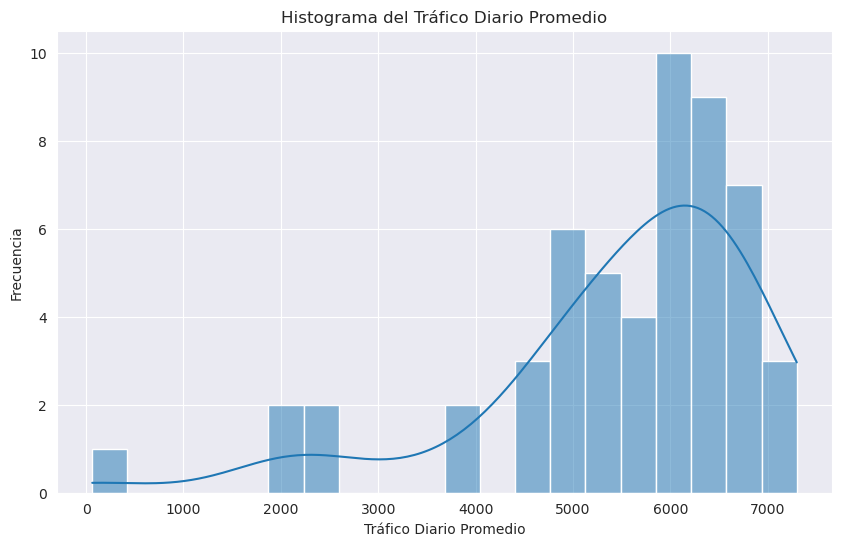

In [44]:
daily_traffic_avg = traffic_df.groupby("Date")["Total"].sum().reset_index()
daily_traffic_avg.rename(columns={"Total": "Trafico_Diario"}, inplace=True)

plt.figure(figsize=(10, 6))
sns.histplot(data=daily_traffic_avg, x="Trafico_Diario", bins=20, kde=True)
plt.title("Histograma del Tráfico Diario Promedio")
plt.xlabel("Tráfico Diario Promedio")
plt.ylabel("Frecuencia")
plt.show()

## Modelo de predicción de tráfico

En esta sección, se realiza un modelo de predicción de tráfico, para lo cual se analizan y seleccionan las variables más relevantes para el mismo.

### Obtención de dummies (*one-hot encoding*) para variables categóricas

Se extraen variables *dummy* para el conjunto de datos con el fin de realizar posteriormente procesos de machine learning, y se activa la opción de **drop_first** para evitar multicolinealidad.

In [45]:
trf_dummies_df = pd.get_dummies(
    traffic_df,
    columns=["clima", "dia_semana"],
    drop_first= True
    )

### Matriz de correlación

Se grafica una matriz de correlación con todas las columnas para verificar que no exista una relación directa o inversa alta entre diferentes columnas del DataFrame a fin de seleccionar las columnas que serán relevantes para las predicciones de tráfico.

In [46]:
correlation_matrix = trf_dummies_df.corr()

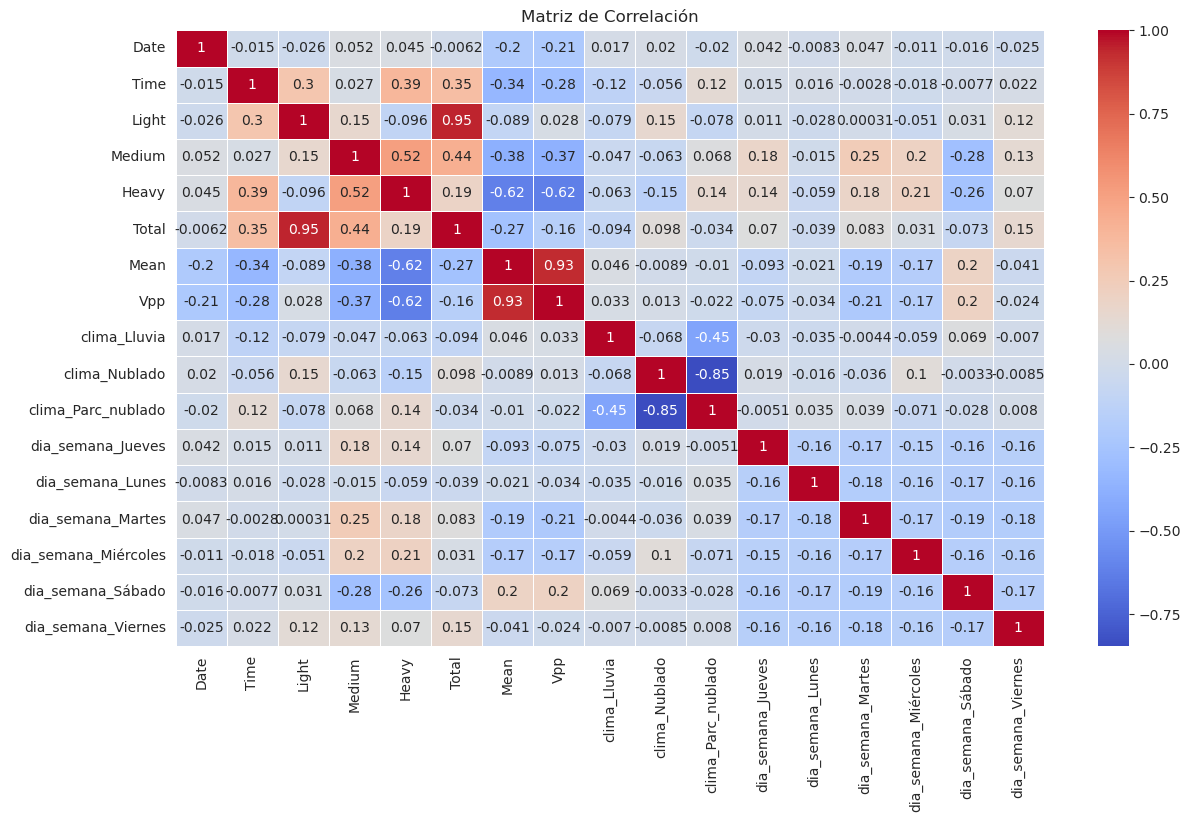

In [47]:
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

### Definición de ***features*** y ***target***

Se definen las features *(características)* y al target *(variable de salida)* que se va a ocupar en el modelo de machine learning. Adicionalmente se suman los valores de las columnas *Medium* y *Heavy*, para tener una variable de salida combinada. Esto porque para la empresa le interesaba principalmente las predicciones en cuanto cambio de volumen de tráfico pesado en general.

In [48]:
# Definir X e y
X = trf_dummies_df[
    ["Time", "Mean", "Total"] +
    list(trf_dummies_df.columns[
        trf_dummies_df.columns.str.startswith("clima_")]) +
    list(trf_dummies_df.columns[
        trf_dummies_df.columns.str.startswith("dia_semana_")])]

y = trf_dummies_df["Medium"] + trf_dummies_df["Heavy"]

### División de los datos en conjunto de entrenamiento y conjunto de pruebas.

In [49]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar la división
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")

Tamaño del conjunto de entrenamiento: 901
Tamaño del conjunto de prueba: 226


### Regresión lineal

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Crear y entrenar el modelo de regresión lineal
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Realizar predicciones
y_pred_lr = lr_model.predict(X_test)

# Evaluar el modelo
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Regresión Lineal - MAE: {mae_lr}, MSE: {mse_lr}, R2: {r2_lr}")

Regresión Lineal - MAE: 15.18285785987343, MSE: 377.79437694693144, R2: 0.5508247075520002


### Regresión de bosques aleatorios

In [51]:
from sklearn.ensemble import RandomForestRegressor

# Crear y entrenar el modelo de Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Realizar predicciones
y_pred_rf = rf_model.predict(X_test)

# Evaluar el modelo
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MAE: {mae_rf}, MSE: {mse_rf}, R2: {r2_rf}")

Random Forest - MAE: 9.382566371681417, MSE: 150.6417256637168, R2: 0.8208958488829595


### Regresión con GradientBoosting

In [52]:
from sklearn.ensemble import GradientBoostingRegressor

# Crear y entrenar el modelo de Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=150, random_state=42)
gb_model.fit(X_train, y_train)

# Realizar predicciones
y_pred_gb = gb_model.predict(X_test)

# Evaluar el modelo
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting - MAE: {mae_gb}, MSE: {mse_gb}, R2: {r2_gb}")

Gradient Boosting - MAE: 8.815679747125365, MSE: 127.68494296189321, R2: 0.8481901132049647


Se contrasta el error cuadrático medio con la varianza.

In [53]:
# Calcular la varianza de las columnas Medium y Heavy
var_medium = traffic_df["Medium"].var()
var_heavy = traffic_df["Heavy"].var()
feature_combo = traffic_df["Medium"] + traffic_df["Heavy"]
var_combo = feature_combo.var()

print(f"Varianza de Medium: {var_medium}")
print(f"Varianza de Heavy: {var_heavy}")
print(f"Varianza de la feature (Medium + Heavy): {var_combo}")

Varianza de Medium: 336.19754421190873
Varianza de Heavy: 242.70668131334293
Varianza de la feature (Medium + Heavy): 873.5242623731094


## Conclusiones

Tal como se obervó previamente, al momento de realizar análisis de datos

Se realizaron 3 modelos de regresión, los cuales son **Regresión Lineal, Random Forest y Gradient Boosting**. El *Error Cuadrático Medio (MSE)* fue menor en **Gradient Boosting** por lo cual se selecciona como mejor modelo.

Se puede ver que, el MSE del modelo es significativamente menor que la varianza de Medium. Esto sugiere que el modelo está capturando una buena cantidad de la variabilidad en los datos y tiene errores relativamente bajos en comparación con la dispersión de los datos de Medium.

El MSE del modelo es además menor a la varianza de Heavy, indicando nuevamente que el modelo está capturando una buena cantidad de la variabilidad en los datos y tiene errores relativamente bajos en comparación con la dispersión de los datos de Heavy.

De igual modo, este MSE es también menor que la varianza de la suma de Medium y Heavy. Esto indica que el modelo de Gradient Boosting está capturando una gran parte de la variabilidad en la variable objetivo combinada.

Es por esto que se puede decir que, el modelo de regresión de Gradient Boosting tiene un buen rendimiento, ya que su MSE es significativamente menor que la varianza de la suma de Medium y Heavy. Esto sugiere que el modelo está haciendo un buen trabajo al capturar la variabilidad en los datos y proporcionando predicciones precisas para la variable objetivo combinada.